In [1]:
import pandas as pd

In [2]:
from tqdm import tqdm

### Adresses

In [3]:
col_adr_i = [(0,2), (2,5), (13,20),
            (110,135), (257,262), (165,190), (160,165),
            (262,263), (263,267), (268,272)]

In [4]:
col_adr_n = ["code province", "code commune", "code unité pop",
            "entité singulière", "code postal", "nom abrégé voie","code voie",
            "type num", "début num", "fin num"]

In [5]:
adr_p02 = r"P02\TRAM.P02.D240630.G240703" # P02
adr_all = r"caj_esp_072024\TRAM.P01-52.D240630.G240703" #  P01-52

In [6]:
adr = pd.read_fwf(adr_all, colspecs=col_adr_i, header=None, encoding='ISO-8859-1', dtype=str)

In [7]:
adr.columns = col_adr_n

In [8]:
adr.head()

,code province,code commune,code unité pop,entité singulière,code postal,nom abrégé voie,code voie,type num,début num,fin num
0,01,001,0001701,ALEGRIA-DULANTZI,01240,TORRONDOA,01001,1,0001,0027
1,01,001,0001701,ALEGRIA-DULANTZI,01240,AÑUA BIDEA,01002,1,0009,0039
2,01,001,0001701,ALEGRIA-DULANTZI,01240,AÑUA BIDEA,01002,2,0004,0024
3,01,001,0001701,ALEGRIA-DULANTZI,01240,GOIKOLANDA,01003,2,0002,0010
4,01,001,0001701,ALEGRIA-DULANTZI,01240,TORREALDEA,01004,1,0005,0005


### Noms de voies

In [9]:
cols_vias_i = [(0,2), (2,5), (22,27), (27,32), 
               (32,33), (33,83), (83,108)]

In [10]:
cols_vias_n = ["code province", "code commune", "code voie", 
               "type de voie", "pos type voie", "nom de voie", "nom court"]

In [11]:
vias_p02 = r"P02\VIAS.P02.D240630.G240703" # P02
vias_all = r"caj_esp_072024\VIAS.P01-52.D240630.G240703" # P01-52

In [12]:
vias = pd.read_fwf(vias_all, colspecs=cols_vias_i, header=None, encoding='ISO-8859-1', dtype=str)

In [13]:
vias.columns = cols_vias_n

In [14]:
vias.head()

,code province,code commune,code voie,type de voie,pos type voie,nom de voie,nom court
0,01,001,01001,KALE,0,TORRONDOA,TORRONDOA
1,01,001,01002,KALE,0,AÑUA BIDEA,AÑUA BIDEA
2,01,001,01003,KALE,0,GOIKOLANDA,GOIKOLANDA
3,01,001,01004,KALE,0,TORREALDEA,TORREALDEA
4,01,001,01005,CALLE,0,NUESTRA SEÑORA DE AIALA,NUESTRA SEÑORA DE AIALA


### préparation corpus

In [15]:
adr_m_vias = pd.merge(adr, vias, on=["code province", "code commune", "code voie"])

In [16]:
adr_m_vias["fin num"] = adr_m_vias["fin num"].astype(int)
adr_m_vias["fin num"] = adr_m_vias["fin num"].astype(str)

In [17]:
adr_m_vias["adresses"] = (adr_m_vias["fin num"]+"<>"+
                         adr_m_vias["type de voie"]+" "+
                         adr_m_vias["nom de voie"]+"<>"+
                         adr_m_vias["code postal"]+"<>"+
                         adr_m_vias["entité singulière"])

In [18]:
adr_m_vias["labels"] = "num rue cp ville"

In [19]:
adr_m_vias[["fin num", "type de voie", "nom de voie", 
            "code postal", "entité singulière", "adresses", "labels"]].head()

,fin num,type de voie,nom de voie,code postal,entité singulière,adresses,labels
0,27,KALE,TORRONDOA,01240,ALEGRIA-DULANTZI,27<>KALE TORRONDOA<>01240<>ALEGRIA-DULANTZI,num rue cp ville
1,39,KALE,AÑUA BIDEA,01240,ALEGRIA-DULANTZI,39<>KALE AÑUA BIDEA<>01240<>ALEGRIA-DULANTZI,num rue cp ville
2,24,KALE,AÑUA BIDEA,01240,ALEGRIA-DULANTZI,24<>KALE AÑUA BIDEA<>01240<>ALEGRIA-DULANTZI,num rue cp ville
3,10,KALE,GOIKOLANDA,01240,ALEGRIA-DULANTZI,10<>KALE GOIKOLANDA<>01240<>ALEGRIA-DULANTZI,num rue cp ville
4,5,KALE,TORREALDEA,01240,ALEGRIA-DULANTZI,5<>KALE TORREALDEA<>01240<>ALEGRIA-DULANTZI,num rue cp ville


### sélection corpus

In [20]:
corpus_size = len(adr_m_vias)
corpus_adr = adr_m_vias["adresses"][:corpus_size].copy()
corpus_lab = adr_m_vias["labels"][:corpus_size].copy()

In [21]:
corpus_adr.head()

0     27<>KALE TORRONDOA<>01240<>ALEGRIA-DULANTZI
1    39<>KALE AÑUA BIDEA<>01240<>ALEGRIA-DULANTZI
2    24<>KALE AÑUA BIDEA<>01240<>ALEGRIA-DULANTZI
3    10<>KALE GOIKOLANDA<>01240<>ALEGRIA-DULANTZI
4     5<>KALE TORREALDEA<>01240<>ALEGRIA-DULANTZI
Name: adresses, dtype: object

In [22]:
corpus_lab.head()

0    num rue cp ville
1    num rue cp ville
2    num rue cp ville
3    num rue cp ville
4    num rue cp ville
Name: labels, dtype: object

### ajout variabilité dans les données

In [23]:
def t(x):
    # inversion du numéro de rue et du nom de rue
    x=x.split("<>")
    num, rue = x[0], x[1]
    x[0], x[1] = rue, num
    return "<>".join(x)

In [24]:
def tl(x):
    # inversion des labels "num" et "rue"
    x=x.split()
    num, rue = x[0], x[1]
    x[0], x[1] = rue, num
    return " ".join(x)

In [25]:
# application de la transformation à 10% des données
freq = int(len(corpus_adr)*0.1)
corpus_adr[:freq] = corpus_adr[:freq].transform(t)
corpus_lab[:freq] = corpus_lab[:freq].transform(tl)

In [26]:
# mélange des données
corpus = pd.DataFrame({"adresses":corpus_adr, "labels":corpus_lab})
corpus = corpus.sample(frac=1)
corpus_adr = corpus["adresses"]
corpus_lab = corpus["labels"]

In [27]:
def t2(x):
    # inversion du code postal et du nom de ville
    x=x.split("<>")
    cp, ville = x[-2], x[-1]
    x[-2], x[-1] = ville, cp
    return "<>".join(x)

In [28]:
def tl2(x):
    # inversion des labels "cp" et "ville"
    x=x.split()
    cp, ville = x[-2], x[-1]
    x[-2], x[-1] = ville, cp
    return " ".join(x)

In [29]:
# application de la transformation à 30% des données
freq = int(len(corpus_adr)*0.3)
corpus_adr[:freq] = corpus_adr[:freq].transform(t2)
corpus_lab[:freq] = corpus_lab[:freq].transform(tl2)

In [30]:
# mélange des données
corpus = pd.DataFrame({"adresses":corpus_adr, "labels":corpus_lab})
corpus = corpus.sample(frac=1)
corpus_adr = corpus["adresses"]
corpus_lab = corpus["labels"]

In [31]:
corpus.head()

,adresses,labels
607283,1<>. PUTZUETA BIDEA<>20115<>TXORITOKIETA,num rue cp ville
243524,0<>CTRA CARDONA CASAS<>08612<>MONTMAJOR,num rue cp ville
7726,CALLE MARZO<>70<>ALBACETE<>02002,rue num ville cp
48998,CALLE CANALOSA-SAN JOSE<>19<>CANALOSA (LA)<>03688,rue num ville cp
926780,10<>CALLE SOCIEDAD<>30012<>BARRIO DEL PROGRESO,num rue cp ville


# Statistical modeling - CRF

Conditional random fields are a type of statiscal model designed to deal with sequential data. They evaluate the transition probability between the sequence elements and their categories. This makes them appropriate for the task of adress parsing where we want to categorize correctly each token of an adress. 

## Data preprocessing

In [45]:
def get_label(i, j, tokens, labels):
    if len(tokens)==1:
        return "U-"+labels[i]
    else:
        if j==0:
            return "B-"+labels[i]
        elif j==(len(tokens)-1):
            return "L-"+labels[i]
        else:
            return "I-"+labels[i]

In [46]:
def process_adress_ner(adress, labels):
    X_adress = []
    y_adress = []
    labels = labels.split()
    elts = adress.split("<>")
    k=0
    for i, elt in enumerate(elts):
        tokens = elt.split()
        for j, t in enumerate(tokens):
            X_adress.append(token_features(adress.replace("<>", " ").split(), k))
            y_adress.append(get_label(i, j, tokens, labels))
            k+=1
    return X_adress, y_adress

In [47]:
# Extract features for each sentence in the corpus
X = []
y = []
for i in tqdm(corpus.index):
    X_adress, y_adress = process_adress_ner(corpus_adr[i], corpus_lab[i])
    X.append(X_adress)
    y.append(y_adress)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

100%|█████████████████████████████████████████████████████████████████████| 1440190/1440190 [00:58<00:00, 24689.11it/s]


### Final data format overview

The adress is transformed into a list of feature dictionaries corresponding to the features of each token. 

In [53]:
corpus.iloc[0]["adresses"]

'1<>. PUTZUETA BIDEA<>20115<>TXORITOKIETA'

In [49]:
X_train[0][:2], "etc"

([{'token': '1',
   'token_length': 1,
   'prev_token': '',
   'next_token': '.',
   'has_hyphen': False,
   'is_numeric': True},
  {'token': '.',
   'token_length': 1,
   'prev_token': '1',
   'next_token': 'PUTZUETA',
   'has_hyphen': False,
   'is_numeric': False}],
 'etc')

The labels are assigned to each token of each adress part following a BILUO tagging strategy indicating the position of the token in the detected adress part (Before, In, Last, Unit and Out).

In [54]:
corpus.iloc[0]["labels"]

'num rue cp ville'

In [50]:
y_train[0]

['U-num', 'B-rue', 'I-rue', 'L-rue', 'U-cp', 'U-ville']

### entraînement / évaluation modèle

In [37]:
### entraînement / évaluation modèle# Train a CRF model on the training data
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)
crf.fit(X_train, y_train)

# Make predictions on the test data and evaluate the performance
y_pred = crf.predict(X_test)

print(metrics.flat_accuracy_score(y_test, y_pred))

loading training data to CRFsuite: 100%|██████████████████████████████████| 1152152/1152152 [01:02<00:00, 18537.64it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 617526
Seconds required: 14.385

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=26.04 loss=16334130.89 active=614439 feature_norm=0.50
Iter 2   time=8.42  loss=15788777.15 active=605152 feature_norm=0.51
Iter 3   time=8.77  loss=15421342.66 active=611351 feature_norm=0.57
Iter 4   time=8.50  loss=10950281.70 active=607588 feature_norm=2.41
Iter 5   time=9.05  loss=5141157.97 active=611554 feature_norm=7.93
Iter 6   time=26.78 loss=4666964.67 active=613922 feature_norm=8.69
Iter 7   time=8.79  loss=3716686.65 active=615546 feature_norm=9.78
Iter 8   time=9.07  loss=2964209.45 active=615274 feature_norm=11.92
Iter 9   time=8.80  loss=2208178.96 active=61334

## Word embeddings

In [114]:
import requests

In [137]:
import requests
import zipfile
import io

# URL du fichier ZIP en ligne
url = 'http://vectors.nlpl.eu/repository/20/68.zip' # lowercased

# Faire une requête GET en mode streaming
response = requests.get(url, stream=True)

# Vérifier que la requête a réussi
if response.status_code == 200:
    # Utiliser un objet BytesIO pour charger le contenu du fichier ZIP dans un flux en mémoire
    fichier_zip = io.BytesIO()

    # Lire et écrire les chunks dans le flux en mémoire
    for chunk in response.iter_content(chunk_size=1024):
        fichier_zip.write(chunk)

    # Remettre le pointeur du flux en début
    fichier_zip.seek(0)
else:
    print(f"Erreur {response.status_code} lors de la récupération du fichier ZIP")

Fichiers dans l'archive ZIP :
['LIST', 'meta.json', 'model.bin', 'model.txt', 'README']

Contenu du fichier LIST :
b'es-common_crawl-257\n'
b'es-common_crawl-328\n'
b'es-common_crawl-119\n'
b'es-common_crawl-199\n'
b'es-common_crawl-172\n'
b'es-common_crawl-141\n'
b'es-common_crawl-017\n'
b'es-common_crawl-296\n'
b'es-common_crawl-330\n'
b'es-common_crawl-350\n'
b'es-common_crawl-046\n'
b'es-common_crawl-189\n'
b'es-common_crawl-077\n'
b'es-common_crawl-059\n'
b'es-common_crawl-102\n'
b'es-common_crawl-084\n'
b'es-common_crawl-283\n'
b'es-common_crawl-204\n'
b'es-wikipedia-013\n'
b'es-common_crawl-312\n'
b'es-common_crawl-343\n'
b'es-common_crawl-074\n'
b'es-common_crawl-249\n'
b'es-common_crawl-342\n'
b'es-common_crawl-377\n'
b'es-common_crawl-033\n'
b'es-common_crawl-022\n'
b'es-common_crawl-006\n'
b'es-common_crawl-365\n'
b'es-common_crawl-062\n'
b'es-common_crawl-336\n'
b'es-common_crawl-166\n'
b'es-common_crawl-021\n'
b'es-common_crawl-383\n'
b'es-wikipedia-015\n'
b'es-wikipedia-0

KeyboardInterrupt: 

In [198]:
# Embeddings metadata
with zipfile.ZipFile(fichier_zip, 'r') as archive_zip:
    with archive_zip.open("meta.json") as fichier:
        print(fichier.read().decode())

{
    "algorithm": {
        "command": "word2vec -min-count 10 -size 100 -window 10 -negative 5 -iter 2 -threads 16 -cbow 0 -binary 0",
        "id": 3,
        "name": "Word2Vec Continuous Skipgram",
        "tool": "word2vec",
        "url": "https://code.google.com/archive/p/word2vec/",
        "version": null
    },
    "contents": [
        {
            "filename": "model.txt",
            "format": "text"
        },
        {
            "filename": "meta.json",
            "format": "json"
        },
        {
            "filename": "LIST",
            "format": "text"
        }
    ],
    "corpus": [
        {
            "NER": false,
            "case preserved": false,
            "description": "Spanish CoNLL17 corpus",
            "id": 68,
            "language": "spa",
            "lemmatized": false,
            "public": true,
            "stop words removal": null,
            "tagger": null,
            "tagset": null,
            "tokens": 5967877096,
           

In [168]:
import numpy as np

embeddings={}
errs=[]

# Ouvrir le fichier ZIP directement depuis le flux en mémoire
with zipfile.ZipFile(fichier_zip, 'r') as archive_zip:
    # Lister les fichiers dans l'archive ZIP
    print("Fichiers dans l'archive ZIP :")
    print(archive_zip.namelist())

    # Extraire et lire chaque fichier dans l'archive sans tout charger en mémoire
    for file_name in archive_zip.namelist():
        with archive_zip.open(file_name) as fichier:
            if file_name=="model.txt":
                # Lire et afficher le contenu de chaque fichier dans l'archive
                print(f"\nContenu du fichier {file_name} :")
                fichier.readline()
                for line in tqdm(fichier):
                    try:
                        line = line.decode().split()
                        embeddings[line[0]] = np.array(line[1:], dtype=float)
                    except UnicodeDecodeError:
                        errs.append(line)

Fichiers dans l'archive ZIP :
['LIST', 'meta.json', 'model.bin', 'model.txt', 'README']

Contenu du fichier model.txt :


2656057it [02:54, 15254.25it/s]


In [211]:
a=[]
for w in embeddings:
    if w.isalpha() and not w.islower():
        a.append(w)

In [230]:
len(embeddings)

2656037

In [223]:
vocab = set()

In [224]:
for lex in nlp.vocab:
    vocab.add(lex.text.lower())

In [225]:
len(vocab)

15656

In [226]:
list(vocab)[:5]

['benalmadena', '03740', 'vizcaino', '39700', 'vargas']

In [233]:
embeddings["benalmadena"]

array([ 0.074875, -0.298918, -0.039462, -0.405561,  0.140007, -0.793524,
       -0.569674,  0.066463,  0.222174,  0.567297,  0.768356, -0.102119,
        0.030638, -0.270314,  0.231208,  0.261223,  1.453737,  0.388108,
       -0.034544,  0.334545,  0.419761,  0.639755, -0.386967, -0.618236,
       -0.207673,  0.163131, -0.091391,  0.117188,  0.748305, -0.600575,
       -0.298912, -0.909222, -0.260297,  0.245753, -0.625691,  0.492283,
        1.000935,  0.807789,  0.598377, -0.469359,  0.37331 ,  0.266725,
       -0.378582,  0.228711,  1.350615,  0.131113,  0.602769,  0.178402,
       -0.610236, -0.340824, -0.267198,  0.535875,  0.122946, -0.261453,
        0.262169, -0.313327,  0.616017, -0.241744,  0.040091, -0.279985,
        0.715574, -0.012725,  0.153394,  0.163833,  0.043303,  0.741668,
        0.098392,  0.253791,  0.446562,  0.425529,  0.043278, -0.14111 ,
        0.318389, -0.325201,  0.233115, -0.56962 ,  0.242946, -0.405108,
       -0.128333,  0.431896,  0.615846,  0.354486, 

In [227]:
oov=set()
for w in vocab:
    if w not in embeddings:
        oov.add(w)

In [228]:
len(oov)

2786

In [229]:
list(oov)[:5]

['coiñas', 'llavanera', 'puigfarners', 'esfiliana', '17181']

# Deep learning

Le problème de parsing d'adresses postales peut se rapprocher d'un problème de reconnaissance d'entités nommées (NER). Il s'agit de classifier une séquence de tokens en sachant qu'une catégorie d'une adresse postale - le nom de la rue, par exemple - peut s'étendre sur plusieurs tokens. Il en est de même pour les entités nommées. Par exemple un nom de personne s'étendra souvent sur 2 tokens ou plus (nom et prénom).  
  
Spacy est une libairie performante pour le problème de reconnaissance des entités nommées. C'est une librairie "high-level" basée sur des réseaux de neurones. C'est cette solution que j'ai choisi pour la partie deep learning de résolution du usecase. 

### Librairie Spacy

L'architecture est composée d'une couche d'embeddings suivie de réseaux convolutifs pour capturer le contexte. L'output sert à prédire la prochaine action à effectuer dans un algorithme de parsing séquentiel de type shift-reduce.  
  
L'inconvénient de cette librairie est son opacité. Il semble par exemple difficile d'accéder aux vecteurs contextuels des mots. De même, il est difficile d'accéder aux features utilisés à l'étape finale de prédiction. Ceux-ci sont malgré tout présentés dans une vidéo du fondateur de Spacy et sont les suivants:  
mot courant, mot précédant, mot suivant; premier et dernier mot de l'entité précédente, dernier mot de l'entité encore avant  
Il n'est pas clair si ces features sont personnalisables ou non, même si cela semble probable étant donné que cette flexibilité est mise en avant comme un des atouts de leur solution.  
  
Concernant les embeddings, il est possible de charger des embeddings pré-entraînés. De même, il est possible de changer leur architecture à base de CNN par une architecture de type transformer.

### Préparation des données

In [21]:
from tqdm import tqdm

In [38]:
def format_data(raw_adress, raw_labels):
    adress_parts = raw_adress.split("<>")
    labels = raw_labels.split()
    labels_new = {"entities":[]}
    left_bound = 0
    for i, ap in enumerate(adress_parts):
        labels_new["entities"].append((left_bound, left_bound+len(ap), labels[i]))
        left_bound += len(ap)+1
    return (raw_adress.replace("<>", " "), labels_new)

In [39]:
data = []
for i in tqdm(range(len(corpus_adr[:10000]))):
    data.append(format_data(corpus_adr.iloc[i], corpus_lab.iloc[i]))

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 11371.47it/s]


In [40]:
split = int(len(data)*0.8)
train_data = data[:split]
test_data = data[split:]

### Initialisation modèle

In [46]:
import spacy

nlp = spacy.blank("es")

ner = nlp.add_pipe("ner")

for label in corpus_lab.iloc[0].split():
    ner.add_label(label)

In [42]:
from spacy.training.example import Example

for i in tqdm(range(len(train_data))):
    text, labels = train_data[i]
    doc = nlp.make_doc(text)
    train_data[i] = Example.from_dict(doc, labels)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 3018.58it/s]


### Entraînement

In [ ]:
from spacy.util import minibatch

optimizer = nlp.begin_training()

batches = minibatch(train_data, size=32)
losses = {}
losses_ner = []
for i, batch in tqdm(enumerate(batches)):
    nlp.update(batch, drop=0.5, losses=losses)
    losses_ner.append(losses["ner"]/((i+1)*32))

In [58]:
import matplotlib.pyplot as plt

In [59]:
x = range(250)
y = losses_ner

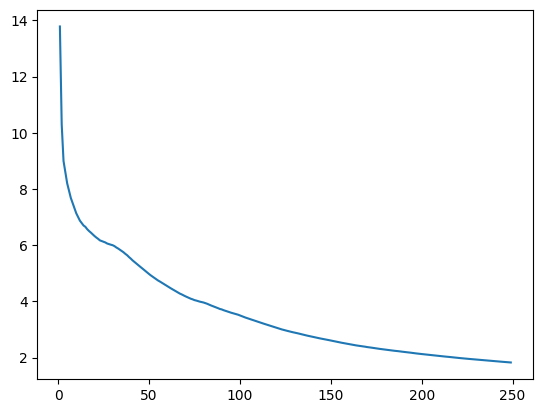

In [60]:
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

### Evaluation

In [44]:
for i in tqdm(range(len(test_data))):
    text, labels = test_data[i]
    doc = nlp.make_doc(text)
    test_data[i] = Example.from_dict(doc, labels)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3091.65it/s]


In [45]:
nlp.evaluate(test_data)

{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'ents_p': 0.9442689245545305,
 'ents_r': 0.934,
 'ents_f': 0.9391063910010683,
 'ents_per_type': {'num': {'p': 0.9940149625935162,
   'r': 0.9965,
   'f': 0.9952559300873908},
  'rue': {'p': 0.8475, 'r': 0.8475, 'f': 0.8475},
  'cp': {'p': 0.9965122072745392, 'r': 1.0, 'f': 0.9982530571499876},
  'ville': {'p': 0.9384534455549711, 'r': 0.892, 'f': 0.9146372724942323}},
 'speed': 9387.397105105245}

In [68]:
for i in range(5):
    doc = nlp(data[-i][0]); print()

    # Parcourir les entités détectées
    for ent in doc.ents:
        print(ent.text, ent.label_)


12 num
CALLE GOYA VEREDA (LA) rue
30300 cp

0 num
RONDA HOSPITAL rue
27700 cp
RIBADEO ville

2 num
CRRIL CIPRESES rue
30139 cp
HUERTA DEL RAAL ville

77 num
CARRE JOSEP NEBOT rue
12540 cp

CALLE BELICE-PUEBLO PRINCIPE rue
1 num
03189 cp
ORIHUELA COSTA ville


In [45]:
# nlp.to_disk("spacy_model")